In [7]:
import numpy as np
import pandas as pd
from scipy.io import arff
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import precision_recall_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns

In [8]:
# Load the dataset
data, meta = arff.loadarff('EEG Eye State.arff')
df = pd.DataFrame(data)

# Convert DataFrame to numeric
df['eyeDetection'] = pd.to_numeric(df['eyeDetection'])

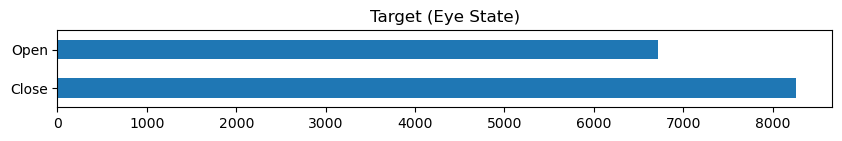

In [9]:
# Display Target 
df['eyeDetection'].value_counts().plot(kind='barh',
                                       title='Target (Eye State)',
                                       figsize=(10, 1))
plt.yticks([0, 1],['Close','Open'])
plt.show()

In [15]:
# Select only the defined features for moving averages
features_ma = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4']

# Select only the defined features
df_filtered = df[features_ma]

# Detect and remove outliers using z-scores
z_scores = stats.zscore(df_filtered)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 10).all(axis=1)
df_filtered = df_filtered[filtered_entries]

# Reset index
df_filtered = df_filtered.reset_index(drop=True)

# Calculate moving averages
df_ma = df_filtered.copy()
for f in features_ma:
    df_ma[f] = df_filtered[f].rolling(window=120, center=False).mean()

In [16]:
# Prepare data for classification
X = df_ma.values  
y = df['eyeDetection'].values
y = y[-len(X):]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_scaled = scaler.transform(X_test.reshape(X_test.shape[0], -1))

In [17]:
# Create an imputer to replace NaN values with the mean of each column
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on the training data and transform both training and testing data
X_train_scaled = imputer.fit_transform(X_train_scaled)
X_test_scaled = imputer.transform(X_test_scaled)

In [18]:
# Convert labels to binary format
y_train_binary = y_train.astype(int)
y_test_binary = y_test.astype(int)

In [19]:
# Multivariate time-series classification using SVM
svm_model = SVC(probability=True)
svm_model.fit(X_train_scaled, y_train_binary)
svm_probabilities = svm_model.predict_proba(X_test_scaled)[:, 1]
svm_precision, svm_recall, _ = precision_recall_curve(y_test_binary, svm_probabilities)
svm_auc = auc(svm_recall, svm_precision)
svm_predictions = svm_model.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test_binary, svm_predictions)
print(f"SVM Accuracy: {svm_accuracy:.2f}")

SVM Accuracy: 0.98


In [20]:
# Multivariate time-series classification using Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_scaled, y_train_binary)
rf_probabilities = rf_model.predict_proba(X_test_scaled)[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(y_test_binary, rf_probabilities)
rf_auc = auc(rf_recall, rf_precision)
rf_predictions = rf_model.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test_binary, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")

Random Forest Accuracy: 1.00


In [22]:
# Multivariate time-series classification using LSTM (Deep Learning)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(64, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(2, activation='softmax'))
lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, to_categorical(y_train_binary), epochs=10, batch_size=32, validation_split=0.2)

lstm_probabilities = lstm_model.predict(X_test_lstm)[:, 1]
lstm_precision, lstm_recall, _ = precision_recall_curve(y_test_binary, lstm_probabilities)
lstm_auc = auc(lstm_recall, lstm_precision)
lstm_predictions = np.round(lstm_probabilities) 
lstm_accuracy = accuracy_score(y_test_binary, lstm_predictions)
print(f"LSTM Accuracy: {lstm_accuracy:.2f}")

Epoch 1/10
300/300 [==============================] - 3s 6ms/step - loss: 0.5853 - accuracy: 0.6635 - val_loss: 0.5236 - val_accuracy: 0.7170
Epoch 2/10
300/300 [==============================] - 1s 4ms/step - loss: 0.4997 - accuracy: 0.7318 - val_loss: 0.5086 - val_accuracy: 0.7241
Epoch 3/10
300/300 [==============================] - 1s 4ms/step - loss: 0.4552 - accuracy: 0.7552 - val_loss: 0.4157 - val_accuracy: 0.7838
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.4030 - accuracy: 0.7916 - val_loss: 0.4238 - val_accuracy: 0.7930
Epoch 5/10
300/300 [==============================] - 1s 4ms/step - loss: 0.3422 - accuracy: 0.8291 - val_loss: 0.3438 - val_accuracy: 0.8264
Epoch 6/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2965 - accuracy: 0.8557 - val_loss: 0.2594 - val_accuracy: 0.8748
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 0.2297 - accuracy: 0.9038 - val_loss: 0.2051 - val_accuracy: 0.9103
Epoch 

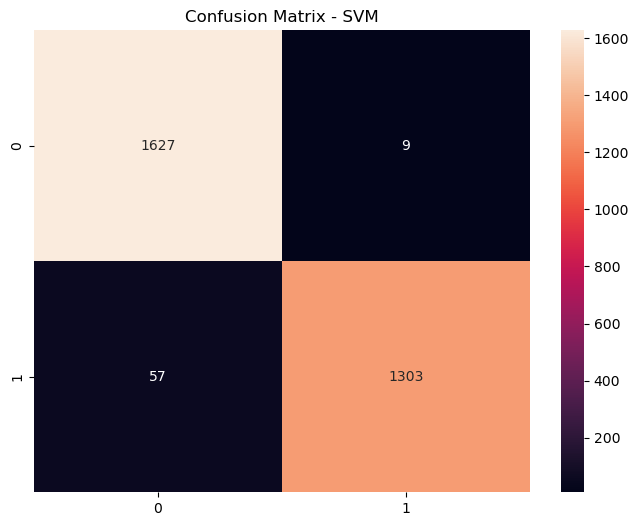

In [23]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(y_test_binary, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_cm, annot=True, fmt="d")
plt.title("Confusion Matrix - SVM")
plt.show()

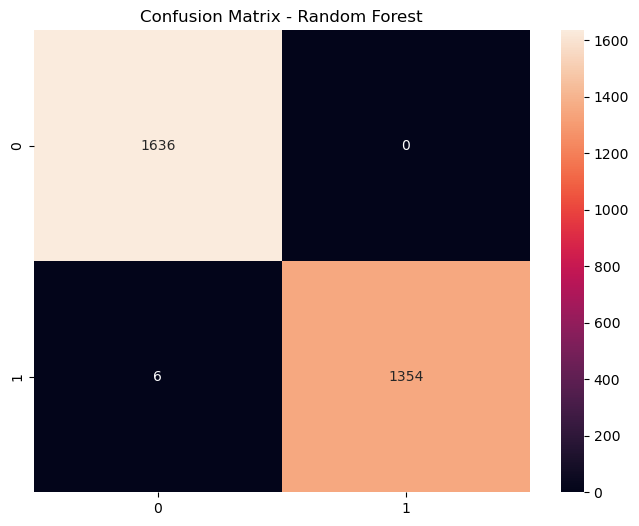

In [24]:
# Confusion Matrix for Random Forest
rf_cm = confusion_matrix(y_test_binary, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt="d")
plt.title("Confusion Matrix - Random Forest")
plt.show()

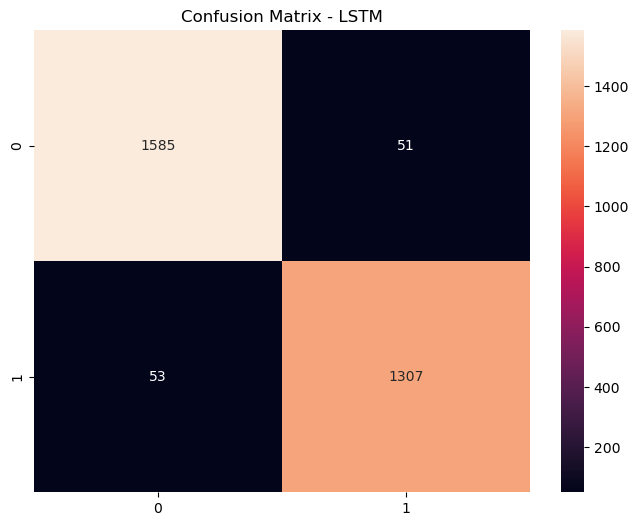

In [25]:
# Confusion Matrix for LSTM
lstm_cm = confusion_matrix(y_test_binary, lstm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(lstm_cm, annot=True, fmt="d")
plt.title("Confusion Matrix - LSTM")
plt.show()

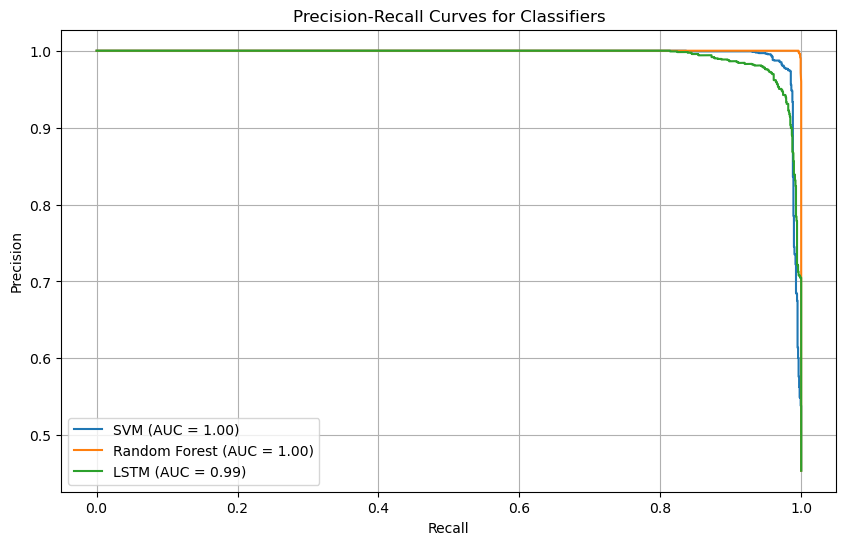

The most accurate classifier is Random Forest with an accuracy of 1.00


In [29]:
# Plot Precision-Recall Curves
plt.figure(figsize=(10, 6))
plt.plot(svm_recall, svm_precision, label=f"SVM (AUC = {svm_auc:.2f})")
plt.plot(rf_recall, rf_precision, label=f"Random Forest (AUC = {rf_auc:.2f})")
plt.plot(lstm_recall, lstm_precision, label=f"LSTM (AUC = {lstm_auc:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for Classifiers")
plt.legend()
plt.grid(True)
plt.show()

# Compare accuracies
accuracies = [svm_accuracy, rf_accuracy, lstm_accuracy]
classifiers = ["SVM", "Random Forest", "LSTM"]
most_accurate = classifiers[np.argmax(accuracies)]
print(f"The most accurate classifier is {most_accurate} with an accuracy of {max(accuracies):.2f}")

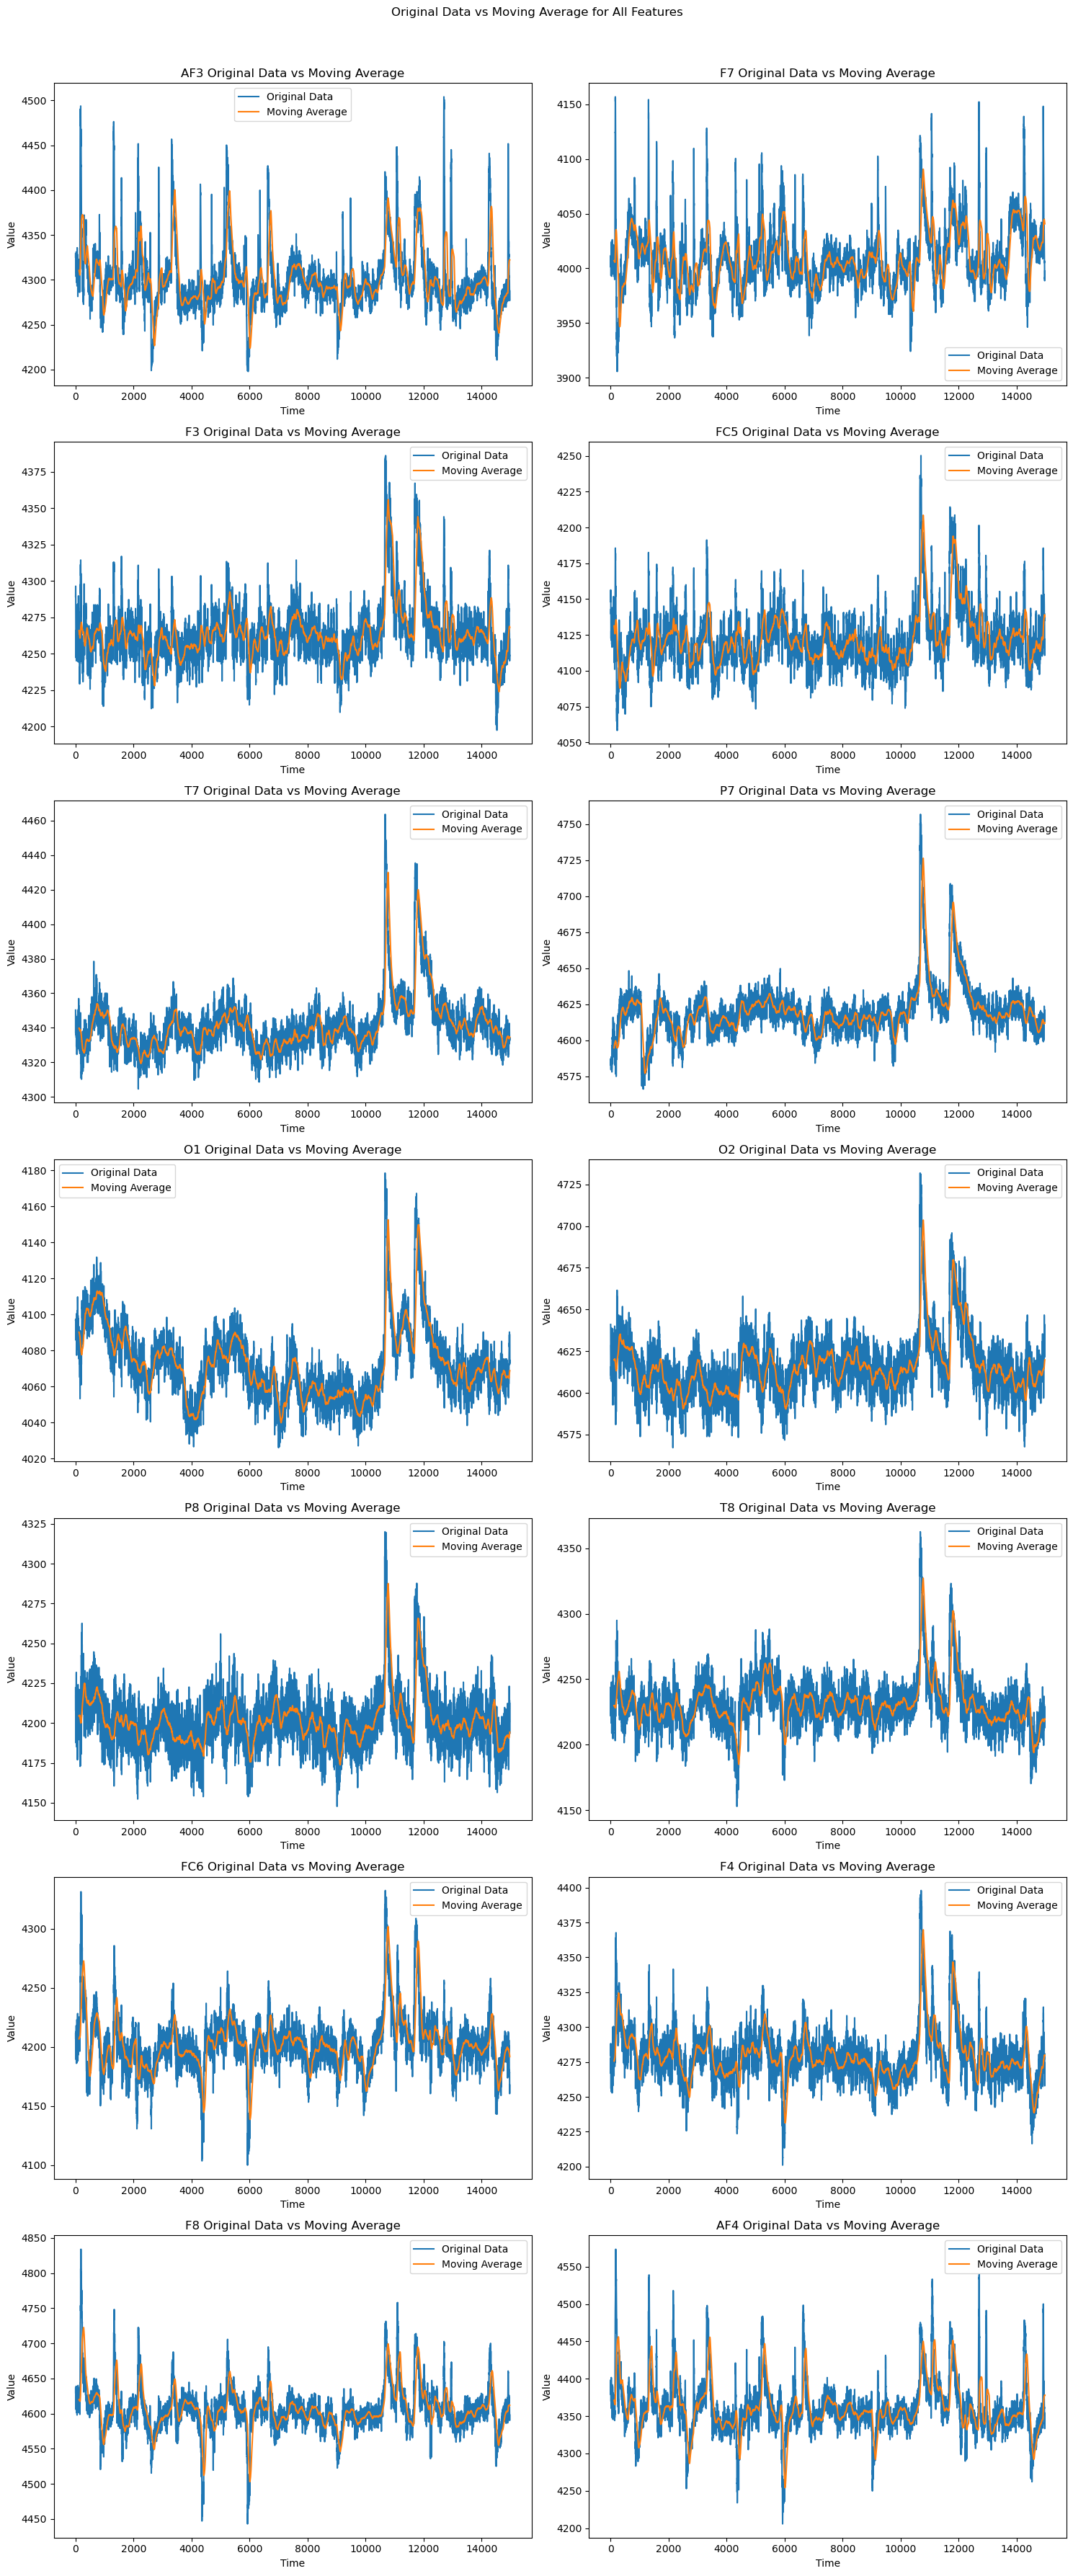

In [28]:
# Calculate moving averages
df_ma = df_filtered.copy()
for f in features_ma:
    df_ma[f] = df_filtered[f].rolling(window=120, center=False).mean()

# Plot original data and moving averages for all features
num_features = len(features_ma)
num_cols = 2
num_rows = (num_features + 1) // num_cols

plt.figure(figsize=(15, 5 * num_rows))
for idx, f in enumerate(features_ma):
    plt.subplot(num_rows, num_cols, idx + 1)
    plt.plot(df_filtered[f], label='Original Data')
    plt.plot(df_ma[f], label='Moving Average')
    plt.title(f'{f} Original Data vs Moving Average')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.tight_layout()

plt.suptitle('Original Data vs Moving Average for All Features', y=1.02)
plt.show()